In [13]:
# Imports
import numpy as np
from scipy import integrate
from tqdm import tqdm
from scipy.special import jv
import matplotlib.pyplot as plt
from numba import jit
import pickle
import os
import warnings
warnings.filterwarnings("ignore")

In [14]:
@jit(nopython=True)
def cutoff_cos(t, tau):
    """
    Computes a cosine taper cutoff function to smoothly transition the integrand
    from 1 to 0, used to model the finite duration of bubble wall interactions
    during the collision in a first-order phase transition.

    Args:
    - t (float): Time variable during the bubble collision.
    - tau (float): Cutoff time, defining the duration of the collision dynamics.

    Returns:
    - float: Cutoff value, 1 for t <= 0.9*τ, smoothly transitions to 0 
    between 0.9*τ and τ using a cosine taper, and 0 for t > τ.
    """
    tau_c = 0.9 * tau
    if 0 <= t <= tau_c:
        return 1.0
    elif tau_c <= t <= tau:
        # Smooth cosine transition in the last 10% of the time domain
        return 0.5 * (1 + np.cos(np.pi * (t - tau_c) / (0.1 * tau)))
    else:
        return 0.0

@jit(nopython=True)
def cutoff(t, tau):
    """
    Computes a Gaussian cutoff function to smoothly transition the integrand
    from 1 to 0, using an exponential decay in the final 10% of the time domain.

    Args:
    - t (float): Time variable during the bubble collision.
    - tau (float): Cutoff time, defining the duration of the collision dynamics.

    Returns:
    - float: Cutoff value, 1 for t <= 0.9*τ, exponential decay for 
    0.9*τ < t <= τ, and 0 for t > τ.
    """
    tau_c = 0.9 * tau
    if 0 <= t <= tau_c:
        return 1.0
    elif tau_c < t <= tau:
        # Exponential decay with Gaussian profile
        return np.exp(-((t - tau_c) / (0.025 * tau))**2)
    else:
        return 0.0

@jit(nopython=True)
def exclude_angle(t, d, vW):
    """
    Calculates the excluded angle alpha(t) based on geometric constraints of the
    bubble collision, used to limit the angular integration range.

    Args:
    - t (float): Time variable during the bubble collision.
    - d (float): Bubble separation distance along the z-axis.
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).

    Returns:
    - float: Excluded angle in radians, arccos(d/(2*vW*t)) for t > d/(2*vW), otherwise 0.
    """
    threshold = d / (2 * vW)
    if t > threshold:
        return np.arccos(d / (2 * vW * t))
    else:
        return 0.0

def base_values(t, d, vW, omega, psi):
    """
    Computes the base values for the gravitational wave response at a given time t
    for faster computation.

    Returns:
    - tuple: Base values for further calculations.
        - theta (np.ndarray): Array of angles for integration.
        - sin_theta (np.ndarray): Sine of angles for integration.
        - cos_theta (np.ndarray): Cosine of angles for integration.
        - trig_arg (np.ndarray): Argument for trigonometric functions.
        - bessel_arg (np.ndarray): Argument for Bessel functions.
    """
    # Calculate upper integration limit based on excluded angle
    upper_limit = np.pi - exclude_angle(t, d, vW)
    
    if upper_limit <= 0:
        return None
    
    # Adaptive number of integration points based on the angular range
    n_points = min(100, max(50, int(upper_limit * 50)))
    theta = np.linspace(0, upper_limit, n_points)
    
    # Precompute trigonometric functions for efficiency
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    # Precompute omega-dependent terms
    omega_cos_psi = omega * np.cos(psi)
    omega_sin_psi = omega * np.sin(psi)
    
    # Arguments for trigonometric and Bessel functions
    trig_arg = omega_cos_psi * vW * t * cos_theta + 0.5 * omega_cos_psi * d
    bessel_arg = omega_sin_psi * vW * t * sin_theta
    
    return theta, sin_theta, cos_theta, trig_arg, bessel_arg
    
def inner_txx(t, omega, psi, vW, d):
    """
    Computes the inner angular integral over theta for the Txx component of the
    stress-energy tensor in the gravitational wave calculation.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.

    Returns:
    - float: Value of the inner integral over theta, representing the angular contribution to the Txx component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals
    
    # Bessel function difference: J_0 - J_2
    bessel_diff = jv(0, bessel_arg) - jv(2, bessel_arg)
    
    # Integrand: geometric factor * phase factor * Bessel contribution
    integrand = sin_theta**3 * np.cos(trig_arg) * bessel_diff
    
    # Numerical integration using trapezoidal rule
    return np.trapz(integrand, theta)

def inner_tyy(t, omega, psi, vW, d):
    """
    Computes the inner angular integral over theta for the Tyy component of the
    stress-energy tensor in the gravitational wave calculation.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.

    Returns:
    - float: Value of the inner integral over theta, representing the angular contribution to the Tyy component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals
    
    # Bessel function sum: J_0 + J_2
    bessel_sum = jv(0, bessel_arg) + jv(2, bessel_arg)
    
    # Integrand: geometric factor * phase factor * Bessel contribution
    integrand = sin_theta**3 * np.cos(trig_arg) * bessel_sum
    
    # Numerical integration using trapezoidal rule
    return np.trapz(integrand, theta)

def inner_tzz(t, omega, psi, vW, d):
    """
    Computes the inner angular integral over theta for the Tzz component of the
    stress-energy tensor in the gravitational wave calculation.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.

    Returns:
    - float: Value of the inner integral over theta, representing the angular contribution to the Tzz component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals
    
    # Bessel function J_0
    bessel_val = jv(0, bessel_arg)
    
    # Integrand: geometric factor * phase factor * Bessel contribution
    integrand = 2 * sin_theta * cos_theta**2 * np.cos(trig_arg) * bessel_val
    
    # Numerical integration using trapezoidal rule
    return np.trapz(integrand, theta)

def inner_txz(t, omega, psi, vW, d):
    """
    Computes the inner angular integral over theta for the Txz component of the
    stress-energy tensor in the gravitational wave calculation.

    Args:
    - t (float): Time variable during the bubble collision.
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.

    Returns:
    - float: Value of the inner integral over theta, representing the angular contribution to the Txz component at time t.
    """
    # Precompute base values for efficiency
    base_vals = base_values(t, d, vW, omega, psi)
    if base_vals is None:
        return 0.0
    
    theta, sin_theta, cos_theta, trig_arg, bessel_arg = base_vals

    # Bessel function J_1
    bessel_val = jv(1, bessel_arg)
    
    # Integrand: geometric factor * phase factor * Bessel contribution
    integrand = - 2 * sin_theta**2 * cos_theta * np.sin(trig_arg) * bessel_val
    
    # Numerical integration using trapezoidal rule
    return np.trapz(integrand, theta)

def tij_unscaled(omega, psi, vW, d, tau, component):
    """
    Computes the unscaled Tij component of the stress-energy tensor for the
    gravitational wave produced by bubble collisions. Returns a complex
    number representing the real and imaginary parts of the response.

    Args:
    - omega (float): Angular frequency of the gravitational wave.
    - psi (float): Azimuthal angle defining the direction k̂ = ω (sin ψ, 0, cos ψ).
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.
    - tau (float): Cutoff time, defining the duration of the collision dynamics.
    - component (str): Component of the stress-energy tensor to compute ("Txx", "Tyy", "Tzz", "Txz").

    Returns:
    - complex: Complex value of the Tij component, with real and imaginary parts
    corresponding to different phase relationships in the GW response.
    """
    # Adaptive number of time integration points based on tau
    n_points = min(100, max(50, int(tau * 2)))
    t_points = np.linspace(0, tau, n_points)
    
    # Initialize arrays for real and imaginary parts
    real_vals = np.zeros(n_points)
    imag_vals = np.zeros(n_points)
    
    # Integrate over time
    for i, t in enumerate(t_points):
        if t == 0:
            continue  # Skip t=0 to avoid potential singularities
            
        # Apply cutoff function for smooth boundary
        cutoff_val = cutoff(t, tau)
        if cutoff_val == 0:
            continue  # Skip points where cutoff is zero
            
        # Calculate inner angular integral
        if component == "xx":
            inner_val = inner_txx(t, omega, psi, vW, d)
        elif component == "yy":
            inner_val = inner_tyy(t, omega, psi, vW, d)
        elif component == "zz":
            inner_val = inner_tzz(t, omega, psi, vW, d)
        elif component == "xz":
            inner_val = inner_txz(t, omega, psi, vW, d)
        
        # Base contribution with t^3 factor
        base = t**3 * cutoff_val * inner_val
        
        # Split into real and imaginary parts
        real_vals[i] = base * np.cos(omega * t)
        imag_vals[i] = base * np.sin(omega * t)
    
    # Integrate real and imaginary parts
    real_part = np.trapz(real_vals, t_points)
    imag_part = np.trapz(imag_vals, t_points)
    
    return real_part + 1j * imag_part

def de_per_domega_unscaled(omega, vW, d, tau, show_progress=True):
    """
    Computes the unscaled differential energy per unit frequency (dE/dω) for
    the gravitational wave spectrum produced by bubble collisions during a
    first-order phase transition, integrating over the orientation angle psi
    to account for all possible wave directions k̂ = ω (sin ψ, 0, cos ψ).

    Args:
    - omega (float): Angular frequency of the gravitational wave.
    - vW (float): Bubble wall velocity (normalized, e.g., close to speed of light = 1).
    - d (float): Bubble separation distance along the z-axis.
    - tau (float): Cutoff time, defining the duration of the collision dynamics.
    - show_progress (bool): If True, prints progress messages. Default: True.

    Returns:
    - float: Unscaled dE/dω value, representing the GW energy radiated per unit 
    frequency at the specified omega.
    """
    if show_progress:
        print(f"Computing for ω = {omega:.4f}:")
    
    # Integration over orientation angle psi with increased number of points
    n_psi = 100
    psi_points = np.linspace(0, np.pi, n_psi)
    
    # Array for integrand values
    integrand_vals = np.zeros(n_psi)
    
    # Compute integrand for each psi
    for i, psi in enumerate(psi_points):
        if np.sin(psi) < 1e-10:  # Skip near-zero contributions
            continue
            
        # Calculate all stress-energy tensor components
        txx_val = tij_unscaled(omega, psi, vW, d, tau, "xx")
        tyy_val = tij_unscaled(omega, psi, vW, d, tau, "yy")
        tzz_val = tij_unscaled(omega, psi, vW, d, tau, "zz")
        txz_val = tij_unscaled(omega, psi, vW, d, tau, "xz")

        # Calculate the expression
        sin_psi = np.sin(psi)
        cos_psi = np.cos(psi)
        expression = (txx_val * cos_psi**2 - 
                      tyy_val +
                      tzz_val * sin_psi**2 - 
                      2 * txz_val * sin_psi * cos_psi)

        # Integrand for dE/dω
        integrand_vals[i] = sin_psi * np.abs(expression)**2
    
    # Final integration over psi
    return np.trapz(integrand_vals, psi_points)

In [15]:
def calculate_rhoVac(alpha, gStar, Tn):
    """
    Computes the vacuum energy density for a 2HDM electroweak phase transition.

    Args:
    - alpha (float): Parameter related to the strength of the phase transition
    - gStar (float): Effective number of degrees of freedom
    - Tn (float): Temperature at the bubble nucleation [GeV]

    Returns:
    - float: Vacuum energy density [GeV^4]
    """
    rhoVac = alpha * np.pi**2 / 30 * gStar * Tn**4

    return rhoVac

def calculate_normalize_factor(G, rhoVac, vW):
    """
    Computes the normalization factor for the gravitational wave spectrum.

    Args:
    - G (float): Gravitational constant [GeV^-2]
    - rhoVac (float): Vacuum energy density [GeV^4]
    - vW (float): Wall velocity [GeV]

    Returns:
    - float: Normalization factor [dimensionless]
    """
    normalize_factor = (2 * np.pi / 9) * G * rhoVac**2 * vW**6

    return normalize_factor

In [16]:
# Bubble separation and collision dynamics
d = 60  # Bubble separation distance along the z-axis
alpha = 1.2  # Scaling factor for time cutoff
tau = alpha * d  # Time cutoff for integration (duration of bubble collision dynamics)
vW = 1  # Bubble wall velocity (normalized, close to speed of light = 1)
gStar = 100  # Effective number of degrees of freedom

# Standard Model reference values
v = 246  # GeV - Standard Model Higgs VEV at T=0
T = 100  # GeV - Critical temperature for first-order phase transition
L = 1 / T  # GeV^-1 - Bubble wall thickness (inverse temperature scale)

# Higgs mixing and CP violation
beta = np.pi / 4  # Mixing angle between the two Higgs doublets
v1 = v * np.cos(beta)  # GeV - VEV of first Higgs field in broken phase
v2 = v * np.sin(beta)  # GeV - VEV of second Higgs field in broken phase
theta_cp = 1  # CP-violating phase parameter (dimensionless)

# Fundamental constants
M_pl = 1.22e19  # GeV - Reduced Planck mass
G = 1 / M_pl**2  # GeV^-2 - Gravitational constant in natural units
R = vW * tau  # Characteristic size scale of bubble collision region

# Benchmark points for C2HDM (PHYSICAL REVIEW D 108, 075010 (2023))
bp1 = {
    "alpha_c": -0.1816,
    "alpha": 0.0227,
    "Tn": 121.04
}
bp2 = {
    "alpha_c": -0.0030,
    "alpha": 0.0142,
    "Tn": 127.22
}
bp3 = {
    "alpha_c": -0.2404,
    "alpha": 0.0262,
    "Tn": 116.81
}
bp4 = {
    "alpha_c": -0.0410,
    "alpha": 0.0642,
    "Tn": 80.78
}

# Vectorized calculation of vacuum energy densities and normalization factors
bps = [bp1, bp2, bp3, bp4]
rhoVac_values = np.array([calculate_rhoVac(bp["alpha"], gStar, bp["Tn"]) for bp in bps])
normalize_factors = np.array([calculate_normalize_factor(G, rhoVac, vW) for rhoVac in rhoVac_values])

# Extract individual values for backward compatibility
rhoVac_1, rhoVac_2, rhoVac_3, rhoVac_4 = rhoVac_values
normalize_factor_1, normalize_factor_2, normalize_factor_3, normalize_factor_4 = normalize_factors

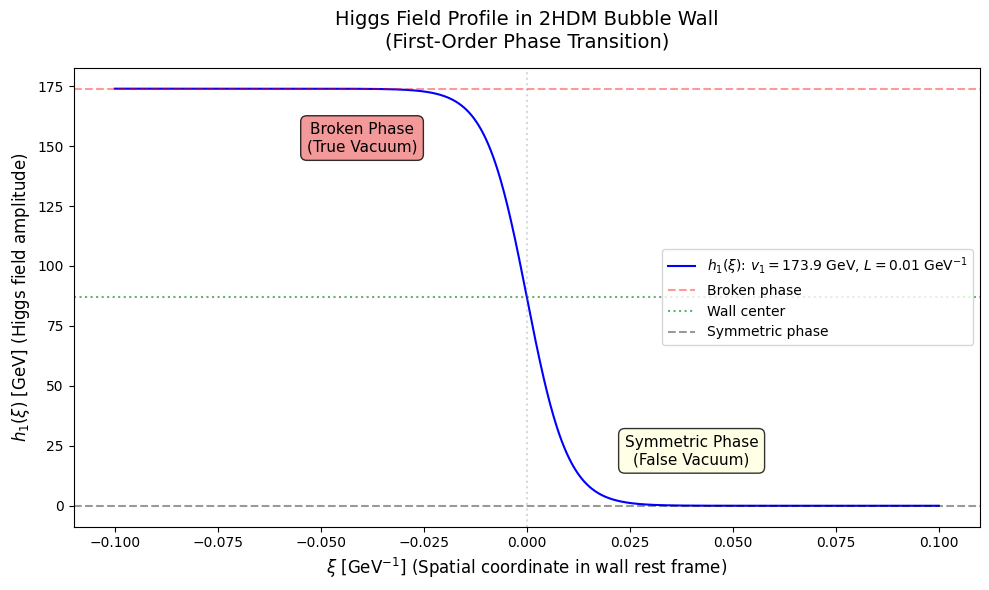

In [21]:
def hi(vi, xi, L):
    """
    Calculates the first Higgs field profile in a Two-Higgs-Doublet Model (2HDM)
    bubble wall during a first-order phase transition.
    
    This function represents a kink solution (domain wall) that smoothly interpolates
    between the symmetric phase (h1 ≈ 0) and the broken symmetry phase (h1 ≈ v1).
    The tanh profile is a common ansatz for bubble wall solutions in cosmological
    phase transitions and provides a stable, traveling wave solution.
    
    Mathematical form: h1(ξ) = (v1/2) * [1 + tanh(ξ/L)]
    
    Args:
    - vi (float): Vacuum expectation value (VEV) of the ith Higgs field in the broken symmetry phase [GeV]
    - xi (float or array): Spatial coordinate(s) in the bubble wall rest frame [GeV^-1]
    - L (float): Wall thickness parameter [GeV^-1] - determines the transition width
    
    Returns:
    - float or array: Value(s) of the ith Higgs field hi(ξ) [GeV]
        
    Note:
        This profile assumes the bubble wall moves from left (symmetric) to right (broken).
        For a wall moving in the opposite direction, use ξ → -ξ.
    """
    return 1 / 2 * vi * (1 - np.tanh(xi / L))

# Create spatial coordinate array spanning multiple wall thicknesses
xi_range = np.linspace(-10*L, 10*L, 1000)  # Cover ±10L for clear asymptotes

# Calculate Higgs field profile across the bubble wall
h1_values = hi(v1, xi_range, L)

# Create publication-quality plot
plt.figure(figsize=(10, 6))
plt.plot(xi_range, h1_values, "b-", label=f"$h_1(\\xi)$: $v_1 = {v1:.4g}$ GeV, $L = {L:.3g}$ GeV$^{{-1}}$")

# Mark important reference levels
plt.axhline(y=v1, color="red", linestyle="--", alpha=0.4, label="Broken phase")
plt.axhline(y=v1/2, color="green", linestyle=":", alpha=0.6, label="Wall center")
plt.axhline(y=0, color="black", linestyle="--", alpha=0.4, label="Symmetric phase")
plt.axvline(x=0, color="gray", linestyle=":", alpha=0.3)

# Add phase annotations with improved positioning
plt.annotate("Broken Phase\n(True Vacuum)", 
             xy=(-4*L, 0.85*v1), fontsize=11, ha="center",
             bbox=dict(boxstyle="round,pad=0.4", facecolor="lightcoral", alpha=0.8))
plt.annotate("Symmetric Phase\n(False Vacuum)", 
             xy=(4*L, 0.1*v1), fontsize=11, ha="center",
             bbox=dict(boxstyle="round,pad=0.4", facecolor="lightyellow", alpha=0.8))

# Enhanced formatting
plt.xlabel("$\\xi$ [GeV$^{-1}$] (Spatial coordinate in wall rest frame)", fontsize=12)
plt.ylabel("$h_1(\\xi)$ [GeV] (Higgs field amplitude)", fontsize=12)
plt.title("Higgs Field Profile in 2HDM Bubble Wall\n(First-Order Phase Transition)", fontsize=14, pad=15)
plt.legend(fontsize=10, loc="center right")

plt.tight_layout()
plt.show()

In [22]:
# Frequency range
n_omega = 500
omega_min = 0.1 / tau
omega_max = 50.0 / tau
omega_values = np.logspace(np.log10(omega_min), np.log10(omega_max), n_omega)

# Create a cache filename based on parameters to ensure consistency
cache_filename = f"gw_spectrum_d{d}_tau{tau:.1f}_vW{vW}_n{n_omega}.pkl"

# Check if cached results exist and load/compute spectrum
if os.path.exists(cache_filename):
    print(f"Loading cached spectrum from {cache_filename}...")
    with open(cache_filename, "rb") as f:
        cached_data = pickle.load(f)
    
    # Verify cached data matches current parameters
    if (np.allclose(cached_data["omega_values"], omega_values) and
        cached_data["d"] == d and cached_data["tau"] == tau and cached_data["vW"] == vW):
        de_per_domega_values = cached_data["de_per_domega_values"]
        print("Successfully loaded cached spectrum data.")
    else:
        print("Cached data mismatch. Recomputing...")
        cached_data = None
else:
    cached_data = None

# Compute spectrum if not cached or cache invalid
if cached_data is None:
    print("Computing gravitational wave spectrum...")

    de_per_domega_values = de_per_domega_unscaled(omega_values, vW, d, tau)

    # Save results to cache
    with open(cache_filename, "wb") as f:
        pickle.dump({
            "omega_values": omega_values,
            "de_per_domega_values": de_per_domega_values,
            "d": d, "tau": tau, "vW": vW
        }, f)
    print(f"Spectrum saved to {cache_filename}")

Loading cached spectrum from gw_spectrum_d60_tau72.0_vW1_n500.pkl...
Successfully loaded cached spectrum data.


In [23]:
# Vectorized normalization for all benchmark points
normalized_spectra = normalize_factors[:, np.newaxis] * de_per_domega_values[np.newaxis, :]

# Remove NaN or infinite values and apply mask efficiently
valid_mask = np.isfinite(de_per_domega_values) & (de_per_domega_values > 0)

# Apply mask once to all arrays
omega_values = omega_values[valid_mask]
de_per_domega_values = de_per_domega_values[valid_mask]

# Apply mask to normalized spectra efficiently
normalized_spectra = normalized_spectra[:, valid_mask]
de_per_domega_values_1, de_per_domega_values_2, de_per_domega_values_3, de_per_domega_values_4 = normalized_spectra


# Power law fitting based on first/last 5% of points
omega_tau = omega_values * tau
n_points = len(omega_tau)
peak_idx = np.argmax(de_per_domega_values)

# Define fitting ranges: first and last 5% of points
low_freq_end = max(3, int(0.05 * n_points))  # Ensure minimum 3 points
high_freq_start = min(n_points - 3, int((1 - 0.05) * n_points))  # Ensure minimum 3 points

# Extract data for fitting
low_freq_x = omega_tau[:low_freq_end]
low_freq_y = de_per_domega_values[:low_freq_end]
high_freq_x = omega_tau[high_freq_start:]
high_freq_y = de_per_domega_values[high_freq_start:]

# Perform power law fitting with error handling
low_power = low_A = low_fit_line = None
high_power = high_A = high_fit_line = None

try:
    # Low frequency power law: y = A * x^power
    if len(low_freq_x) >= 2:
        low_freq_log_fit = np.polyfit(np.log10(low_freq_x), np.log10(low_freq_y), 1)
        low_power = low_freq_log_fit[0]
        low_A = 10**low_freq_log_fit[1]
        low_fit_line = low_A * low_freq_x**low_power

    # High frequency power law: y = A * x^power
    if len(high_freq_x) >= 2:
        high_freq_log_fit = np.polyfit(np.log10(high_freq_x), np.log10(high_freq_y), 1)
        high_power = high_freq_log_fit[0]
        high_A = 10**high_freq_log_fit[1]
        high_fit_line = high_A * high_freq_x**high_power

except (ValueError, np.linalg.LinAlgError) as e:
    print(f"Warning: Power law fitting failed: {e}")

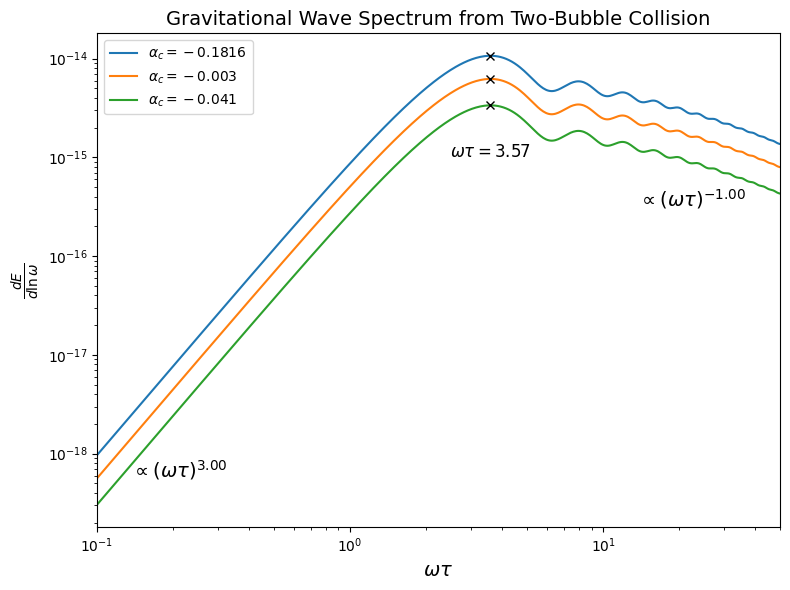

In [24]:
# Create the spectrum plot
plt.figure(figsize=(8, 6))

# Main spectrum data
spectrum_data = [
    (de_per_domega_values_1, bps[0]),
    (de_per_domega_values_2, bps[1]),
    (de_per_domega_values_3, bps[2]),
    (de_per_domega_values_4, bps[3])
]

# Plot only 1st, 3rd, and 4th spectra
plotted_values = []
for i, idx in enumerate([0, 1, 3]):
    val, bp = spectrum_data[idx]
    alpha_c = bp["alpha_c"]
    label = f"$\\alpha_c={alpha_c:.4g}$"
    plt.loglog(omega_tau, val, label=label)
    plt.loglog(omega_tau[peak_idx], val[peak_idx], marker="x", color="black")
    plotted_values.append(val)

# Find the lowest curve and add annotation at its peak
min_values_at_peak = [val[peak_idx] for val in plotted_values]
lowest_curve_idx = np.argmin(min_values_at_peak)
lowest_value_at_peak = min_values_at_peak[lowest_curve_idx]

# Add annotation below the lowest curve at peak position
plt.annotate(f"$\\omega\\tau={omega_tau[peak_idx]:.2f}$", 
             xy=(omega_tau[peak_idx], lowest_value_at_peak),
             xytext=(omega_tau[peak_idx], lowest_value_at_peak * 0.3),
             fontsize=12, ha="center")

# Plot power law fits if available
if low_power is not None:
    # Add text annotation for low frequency power law at lower left
    plt.text(0.05, 0.1, rf"$\propto (\omega\tau)^{{{low_power:.2f}}}$", 
             transform=plt.gca().transAxes, fontsize=14, color="black")

if high_power is not None:
    # Add text annotation for high frequency power law at upper right
    plt.text(0.95, 0.65, rf"$\propto (\omega\tau)^{{{high_power:.2f}}}$", 
             transform=plt.gca().transAxes, fontsize=14, color="black", 
             horizontalalignment="right")

# Enhanced plot formatting
plt.xlabel(r"$\omega\tau$", fontsize=14)
plt.xlim([omega_tau[0], omega_tau[-1]])
plt.ylabel(r"$\frac{dE}{d\ln\omega}$", fontsize=14)
plt.title("Gravitational Wave Spectrum from Two-Bubble Collision", fontsize=14)
plt.legend(loc="best", fontsize=10)

plt.tight_layout()
plt.savefig("Figure/gwplot_twobubble.png", dpi=300, bbox_inches="tight")
plt.show()